In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Connect to your DB
con = duckdb.connect("/Users/koosha/00-My Files-00/My Works/GitHub/Repositories/BNPL_Customer_Data/BNPL_customer_data/dev.duckdb", read_only=True)


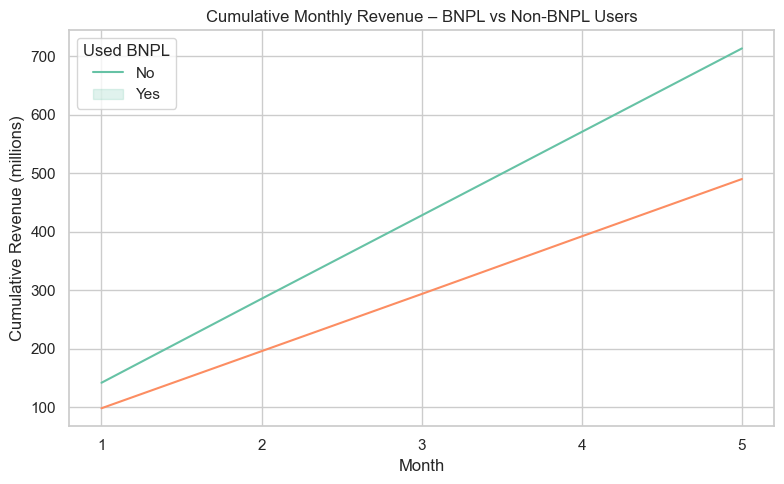

In [21]:
query = """
select month_id, user_type, sum(cumulative_revenue)/1000000 as cumulative_revenue
from mart_bnpl_revenue_trend
group by month_id, user_type
order by month_id, user_type
"""

df = con.execute(query).fetchdf()

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="month_id", y="cumulative_revenue", hue="user_type", palette="Set2")
plt.title("Cumulative Monthly Revenue – BNPL vs Non-BNPL Users")
plt.xlabel("Month")
plt.ylabel("Cumulative Revenue (millions)")
plt.xticks([1, 2, 3, 4, 5])
plt.legend(title="Used BNPL", labels=["No", "Yes"])
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:

query = """
select month_id, used_bnpl, avg_recharge, avg_direct_channel, avg_bundle_count
from mart_bnpl_usage_behavior
"""

df = con.execute(query).fetchdf()



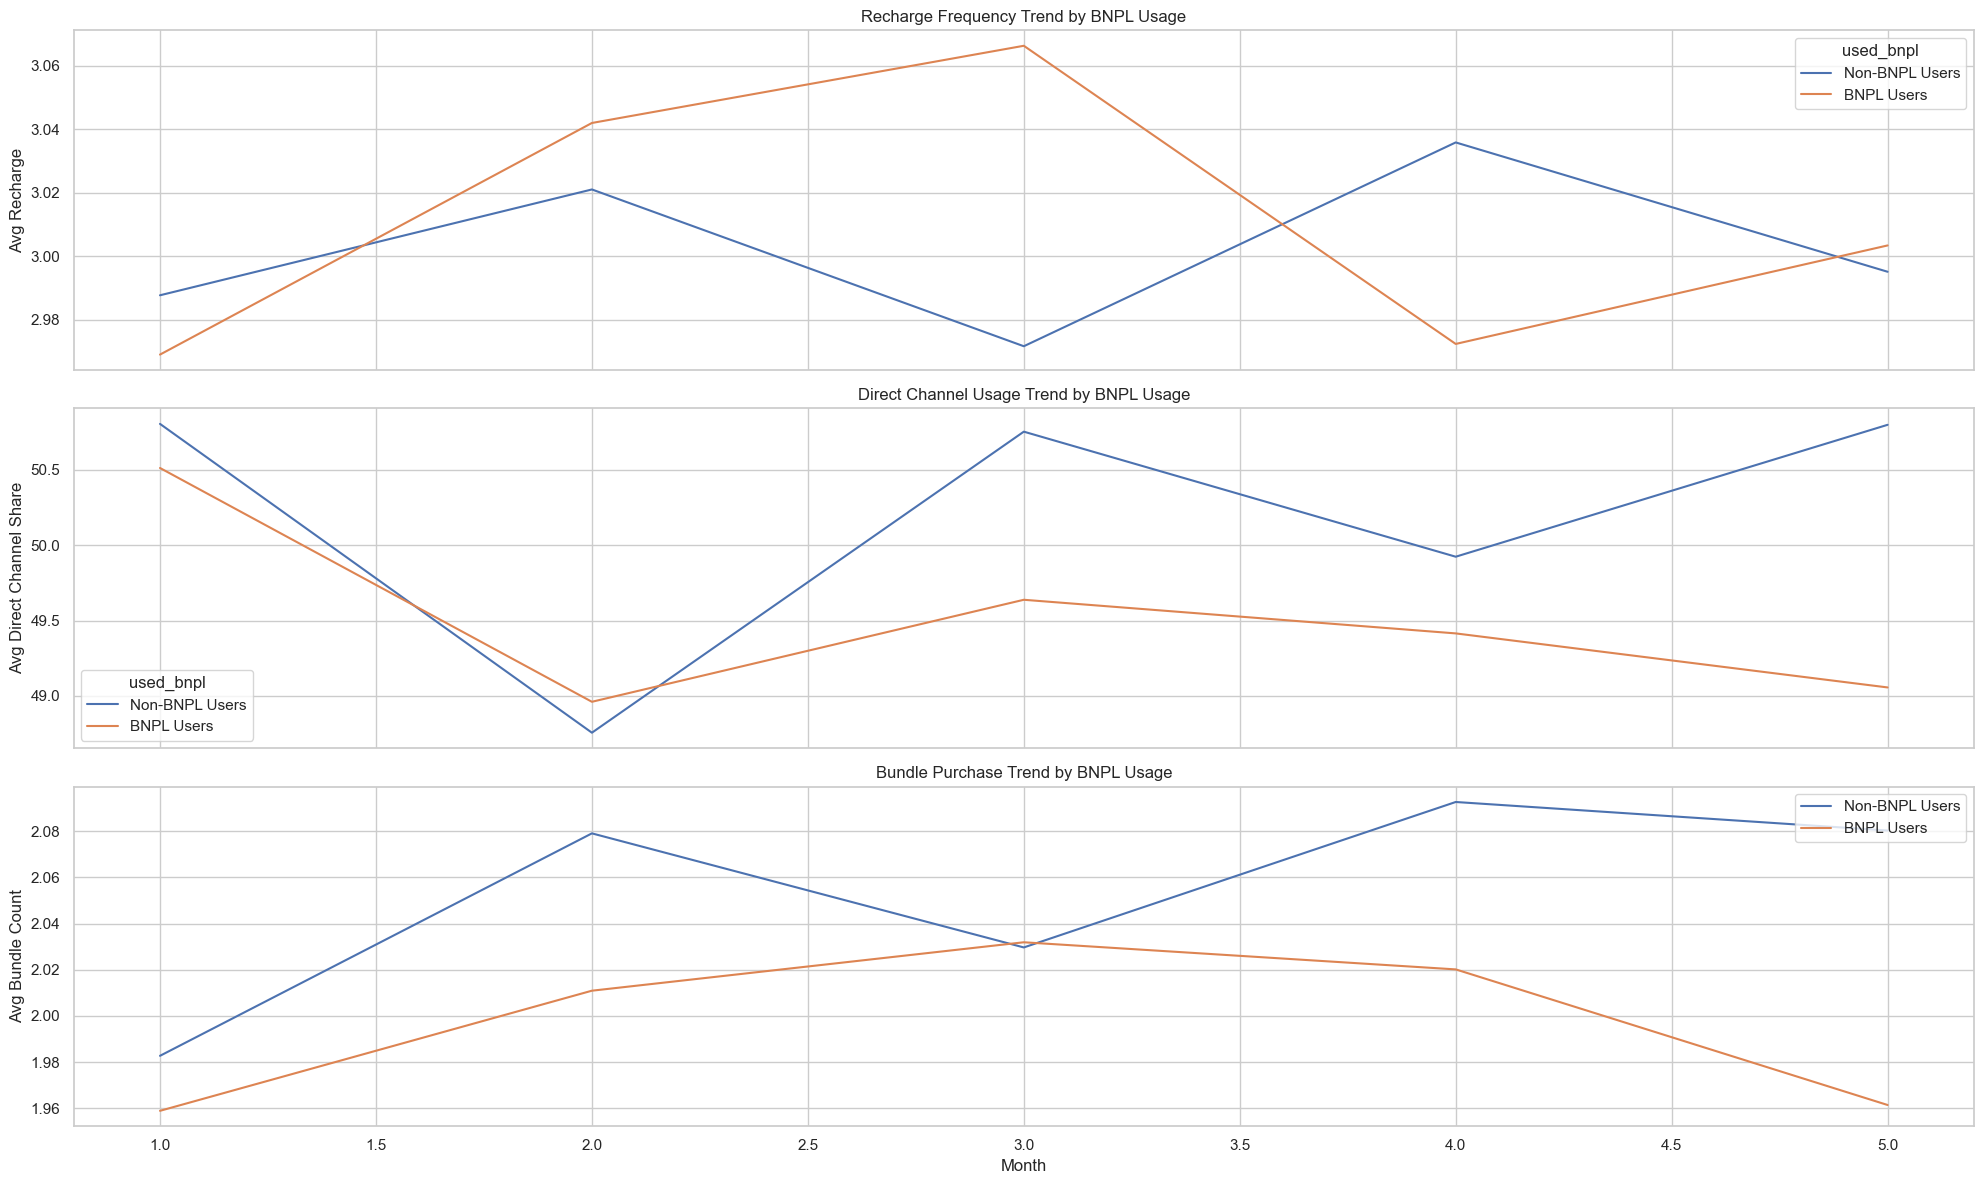

In [ ]:

df['used_bnpl'] = df['used_bnpl'].map({'Non-BNPL': 'Non-BNPL Users', 'BNPL': 'BNPL Users'})

# Set visual style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Plot 1: avg_recharge trend
sns.lineplot(data=df, x="month_id", y="avg_recharge", hue="used_bnpl", ax=axes[0])
axes[0].set_title("Recharge Frequency Trend by BNPL Usage")
axes[0].set_ylabel("Avg Recharge")
axes[0].set_xlabel("")

# Plot 2: avg_direct_channel trend
sns.lineplot(data=df, x="month_id", y="avg_direct_channel", hue="used_bnpl", ax=axes[1])
axes[1].set_title("Direct Channel Usage Trend by BNPL Usage")
axes[1].set_ylabel("Avg Direct Channel Share")
axes[1].set_xlabel("")

# Plot 3: avg_bundle_count trend
sns.lineplot(data=df, x="month_id", y="avg_bundle_count", hue="used_bnpl", ax=axes[2])
axes[2].set_title("Bundle Purchase Trend by BNPL Usage")
axes[2].set_ylabel("Avg Bundle Count")
axes[2].set_xlabel("Month")

# Tight layout & single legend
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

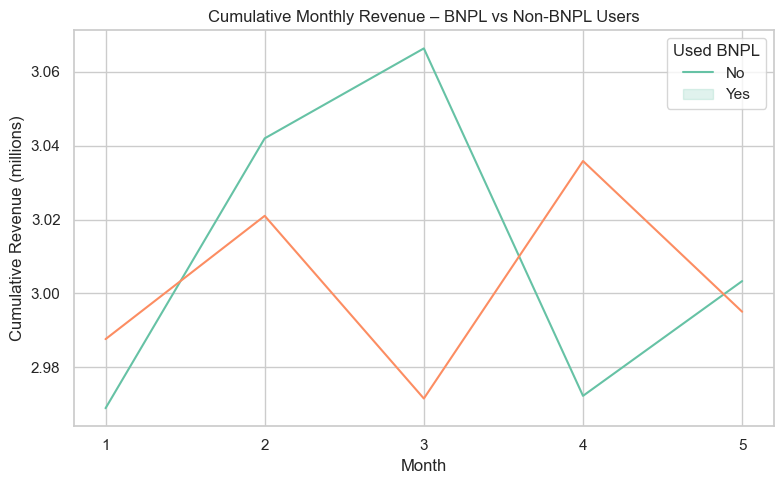

In [29]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="month_id", y="avg_recharge", hue="used_bnpl", palette="Set2")
plt.title("Cumulative Monthly Revenue – BNPL vs Non-BNPL Users")
plt.xlabel("Month")
plt.ylabel("Cumulative Revenue (millions)")
plt.xticks([1, 2, 3, 4, 5])
plt.legend(title="Used BNPL", labels=["No", "Yes"])
plt.grid(True)
plt.tight_layout()
plt.show()

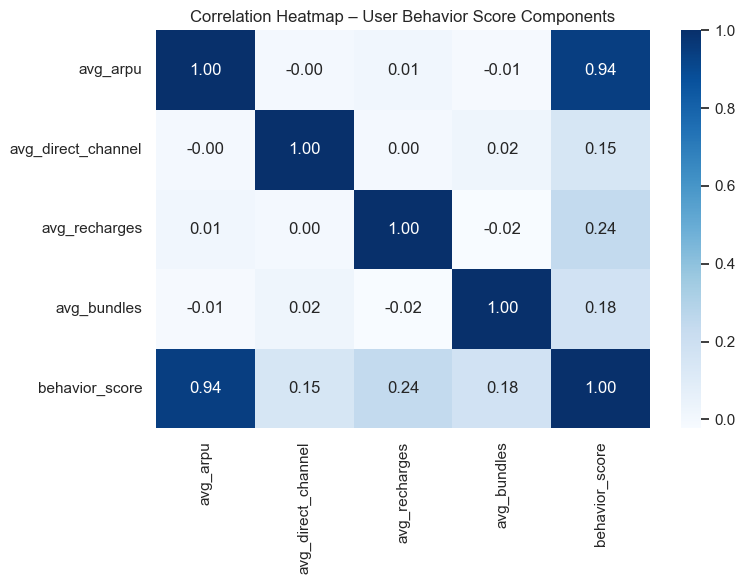

In [27]:
query = "select * from mart_user_behavior_score"
df = con.execute(query).fetchdf()

corr = df.drop(columns=["user_id"]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap – User Behavior Score Components")
plt.tight_layout()
plt.show()


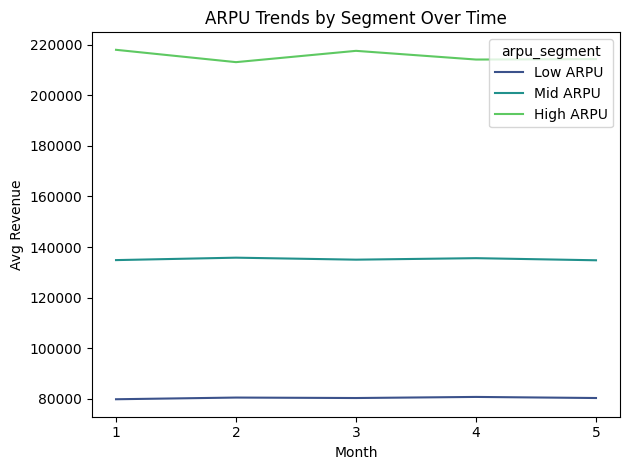

In [2]:
query = """
select arpu_segment, month_id, avg(avg_monthly_revenue) as avg_arpu
from mart_arpu_segmentation
group by arpu_segment, month_id
"""

df = con.execute(query).fetchdf()

sns.lineplot(data=df, x="month_id", y="avg_arpu", hue="arpu_segment", palette="viridis")
plt.title("ARPU Trends by Segment Over Time")
plt.xlabel("Month")
plt.ylabel("Avg Revenue")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


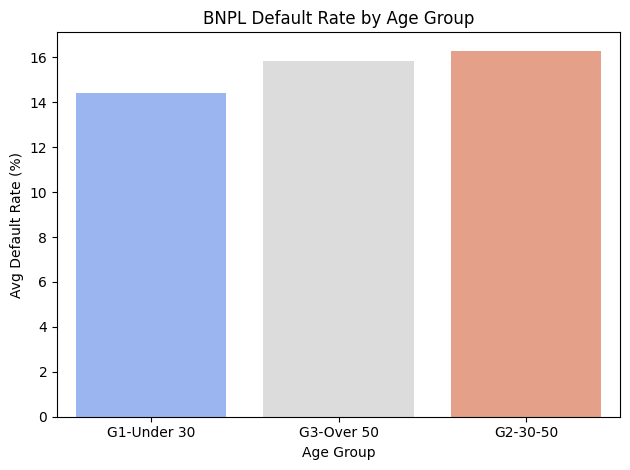

In [5]:
query = """
select case 
         when age < 30 then 'G1-Under 30'
         when age between 30 and 50 then 'G2-30-50'
         else 'G3-Over 50'
       end as age_group,
       avg(default_rate_pct) as avg_default_rate
from mart_bnpl_default_rate
group by age_group
"""

df = con.execute(query).fetchdf()

sns.barplot(data=df, x="age_group", y="avg_default_rate", palette="coolwarm")
plt.title("BNPL Default Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Avg Default Rate (%)")
plt.tight_layout()
plt.show()


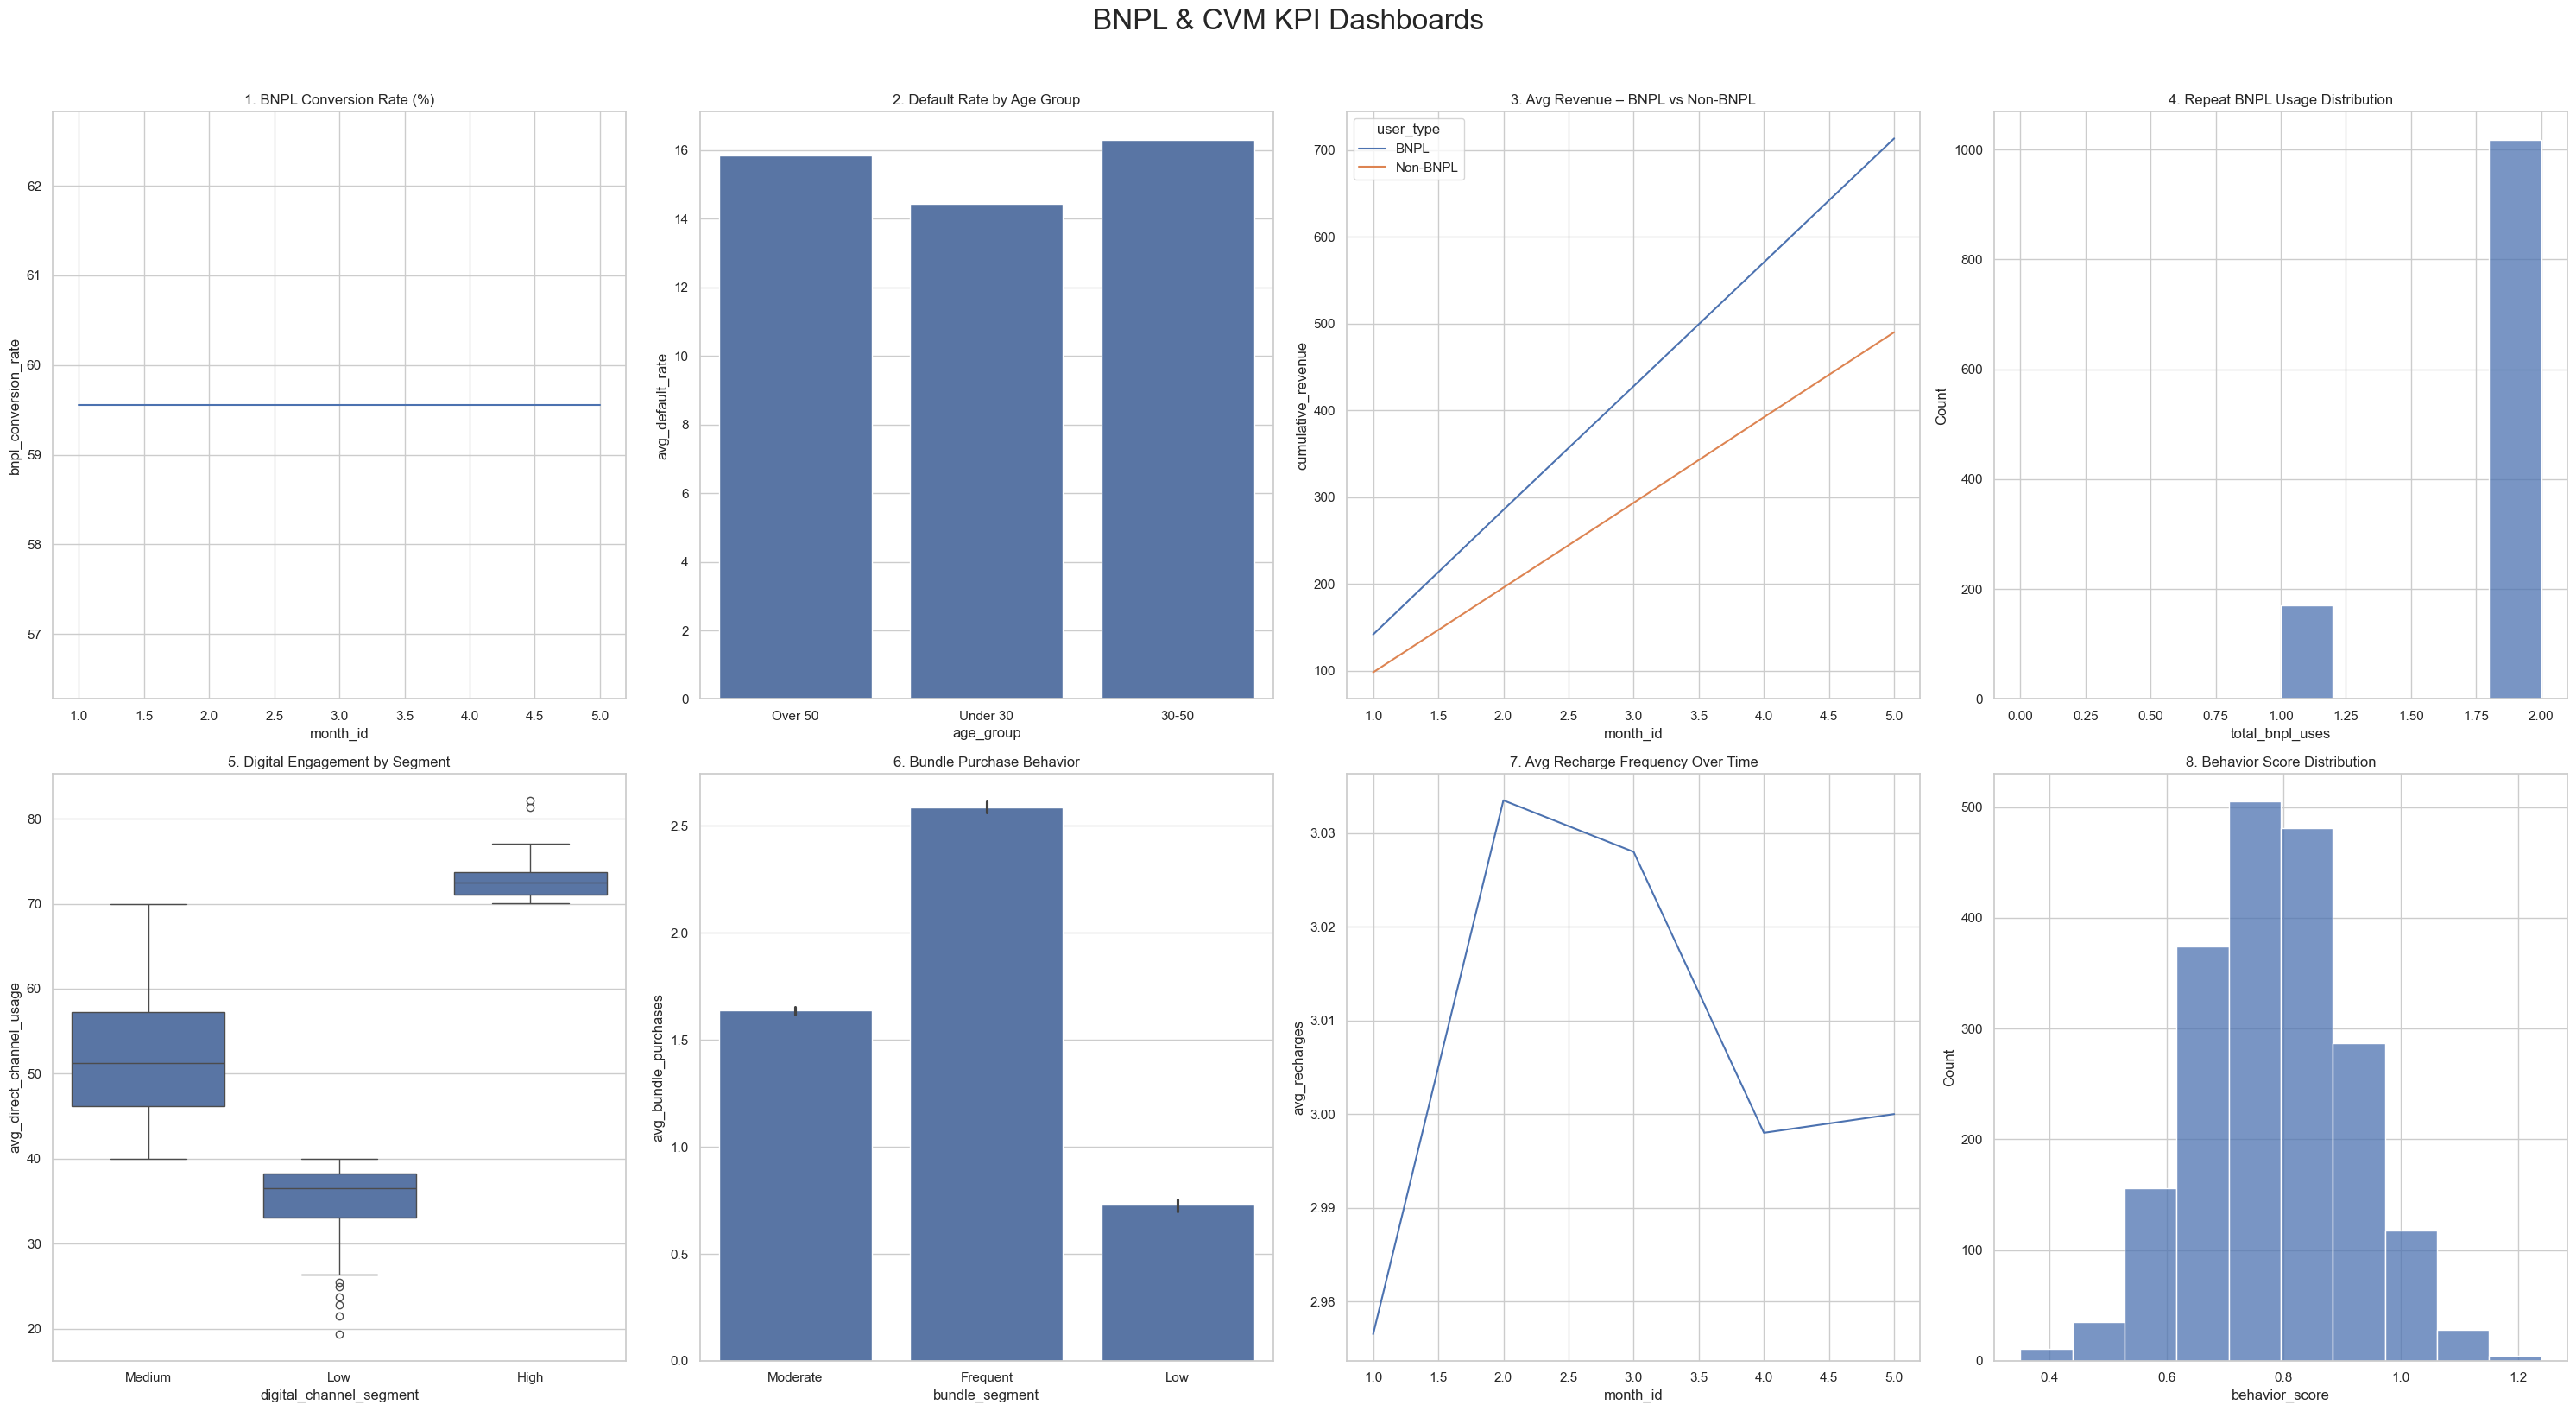

In [ ]:


# Set up subplots
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(30, 16))
fig.suptitle("BNPL & CVM KPI Dashboards", fontsize=24, y=1.02)

# KPI 1 – BNPL Conversion Rate
df1 = con.execute("""
    select month_id,
           round(100.0 * sum(case when bnpl_amount > 0 then 1 else 0 end) / count(*), 2) as bnpl_conversion_rate
    from stg_BNPL_customer
    group by month_id
    order by month_id
""").fetchdf()
sns.lineplot(data=df1, x="month_id", y="bnpl_conversion_rate", ax=axes[0, 0])
axes[0, 0].set_title("1. BNPL Conversion Rate (%)")

# KPI 2 – BNPL Default Rate by Age Group
df2 = con.execute("""
    select case 
      when age < 30 then 'Under 30'
      when age between 30 and 50 then '30-50'
      else 'Over 50'
    end as age_group,
    avg(default_rate_pct) as avg_default_rate
    from mart_bnpl_default_rate
    group by age_group
""").fetchdf()
sns.barplot(data=df2, x="age_group", y="avg_default_rate", ax=axes[0, 1])
axes[0, 1].set_title("2. Default Rate by Age Group")

# KPI 3 – ARPU Lift (BNPL vs Non-BNPL)
df3 = con.execute("""
        select month_id, user_type, sum(cumulative_revenue)/1000000 as cumulative_revenue
        from mart_bnpl_revenue_trend
        group by month_id, user_type
        order by month_id, user_type
""").fetchdf()
sns.lineplot(data=df3, x="month_id", y="cumulative_revenue", hue="user_type", ax=axes[0, 2])
axes[0, 2].set_title("3. Avg Revenue – BNPL vs Non-BNPL")

# KPI 4 – Repeat BNPL Usage
df4 = con.execute("""
    select total_bnpl_uses from mart_bnpl_repeat_users
""").fetchdf()
sns.histplot(df4, x="total_bnpl_uses", bins=10, ax=axes[0, 3])
axes[0, 3].set_title("4. Repeat BNPL Usage Distribution")

# KPI 5 – Digital Engagement (Direct Channel Usage)
df5 = con.execute("""
    select avg_direct_channel_usage, digital_channel_segment
    from mart_channel_preference
""").fetchdf()
sns.boxplot(data=df5, x="digital_channel_segment", y="avg_direct_channel_usage", ax=axes[1, 0])
axes[1, 0].set_title("5. Digital Engagement by Segment")

# KPI 6 – Bundle Attach Rate
df6 = con.execute("""
    select bundle_segment, avg_bundle_purchases
    from mart_bundle_behavior
""").fetchdf()
sns.barplot(data=df6, x="bundle_segment", y="avg_bundle_purchases", ax=axes[1, 1])
axes[1, 1].set_title("6. Bundle Purchase Behavior")

# KPI 7 – Churn Risk Proxy (Recharge Frequency Over Time)
df7 = con.execute("""
    select month_id, avg(recent_recharge_freq) as avg_recharges
    from stg_BNPL_customer
    group by month_id
    order by month_id
""").fetchdf()
sns.lineplot(data=df7, x="month_id", y="avg_recharges", ax=axes[1, 2])
axes[1, 2].set_title("7. Avg Recharge Frequency Over Time")

# KPI 8 – Composite Behavior Score
df8 = con.execute("""
    select behavior_score from mart_user_behavior_score
""").fetchdf()
sns.histplot(df8, x="behavior_score", bins=10, ax=axes[1, 3])
axes[1, 3].set_title("8. Behavior Score Distribution")

# Final touch
plt.tight_layout()
plt.show()
